Correct genotype

- 5wk WT= 7202, 72921, 72922
- 5wk SCA1= 7294, 72931, 72932
- 12wk wild-type: 22018, 2061, 2062
- 12wk SCA1: 22019, 2063, 2065
- 18wk WT: 6569, 65701, 65702
- 18wk SCA1: 6571, 65731, 65732
- 24wk wild-type: 1974, 2020, 20202
- 24wk SCA1: 1589, 2021, 20212

- 30wk WT: 5812, #5822, 58232
- 30wk SCA1: #58231, 58241, 58242

In [1]:
# Import packages
import os, sys, glob, re, math, pickle
import phate, scprep, magic, meld
import graphtools as gt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import time,random,datetime
import networkx as nx
import scvelo as scv
from sklearn import metrics
from sklearn import model_selection
from scipy import sparse
from scipy.stats import mannwhitneyu, tiecorrect, rankdata
from statsmodels.stats.multitest import multipletests
import scanpy as sc
from sklearn.dummy import DummyClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import SpectralClustering, OPTICS, cluster_optics_dbscan, AgglomerativeClustering
from bbknn import bbknn
%matplotlib inline
%load_ext memory_profiler


In [2]:
import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

In [3]:
# settings
plt.rc('font', size = 8)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['text.usetex']=False
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=0.5
sc.set_figure_params(dpi=300,dpi_save=600,
                     frameon=False,
                     fontsize=8)
plt.rcParams['savefig.dpi']=600
sc.settings.verbosity=2
sc._settings.ScanpyConfig.n_jobs=-1


In [4]:
# fps
dfp = '/home/cl2292/project/SCA1_snRNAseq/Mouse/data/'
pfp = '/home/cl2292/project/SCA1_snRNAseq/Mouse/results/'
sc.settings.figdir = pfp

In [5]:
# Load Data

if True :
    start = time.time()
    backed=None # None if not
    fname='211027_mouse.h5ad' # for full, can maybe get away with ~300G
    %memit adata = sc.read_h5ad(os.path.join(dfp,fname),backed=backed)
    print('loaded @'+datetime.datetime.now().strftime('%y%m%d.%H:%M:%S'))
    print('took {:.2f}-s to load data'.format(time.time()-start))
    

peak memory: 10882.11 MiB, increment: 10566.21 MiB
loaded @220328.10:00:52
took 21.69-s to load data


In [6]:
# annotate metadata
WT = ['7202', '72921', '72922',   #5wk
      '22018', '2061', '2062',    #12wk
      '6569', '65701', '65702',   #18wk
      '1974', '2020', '20202',    #24wk
      '5812', '5822', '58232']   #30wk 58231 -> 5822
SCA1 = ['7294', '72931', '72932', #5wk
        '22019', '2063', '2065',  #12wk
        '6571', '65731', '65732', #18wk
        '1589', '2021', '20212',  #24wk
        '58231', '58241', '58242'] #30wk 5822 -> 58231
genotype = []
for i in adata.obs['batch'] : # verbose loop for quality-assurance
    if i in WT :
        genotype.append('WT')
    elif i in SCA1 :
        genotype.append('SCA1')
    else :
        raise ValueError('Encountered unclassifiable genotype for animal {}'.format(i))
adata.obs['genotype']=genotype


print(adata)

AnnData object with n_obs × n_vars = 318312 × 26374
    obs: 'batch', 'genotype', 'timepoint', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pmito', 'n_genes', 'louvain', 'res_sca1', 'ees_sca1', 'stored_ctype', 'ctype', 'sub1', 'sub2', 'sub3', 'sub4'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'ctype_colors', 'louvain', 'neighbors', 'pca', 'sub1_colors', 'sub2_colors', 'sub3_colors', 'umap'
    obsm: 'X_pca', 'X_phate', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


In [ ]:
## Imputation by genotype
#k=45, t=3
print('Starting imputation for {}\n'.format('WT'))
tic = time.time()

wt = adata[adata.obs['genotype']=='WT', :]
wt.obs['value'] = 0
sc.pp.pca(wt)
sc.pp.neighbors(wt, n_pcs=45)


# MAGIC
G = gt.Graph(data=wt.obsp['connectivities']+sparse.diags([1]*wt.shape[0],format='csr'),
             precomputed='adjacency',
             use_pygsp=True)
G.knn_max = None

# MAGIC
magic_op=magic.MAGIC().fit(X=wt.X,graph=G) # running fit_transform produces wrong shape
wt.layers['imputed']=magic_op.transform(wt.X,genes='all_genes')

print('\n  imputation in {:.2f}-min'.format((time.time() - tic)/60))


# save data objects
wt.write(os.path.join(dfp,'220325_WT_imp.h5ad'))
print('saved @'+datetime.datetime.now().strftime('%y%m%d.%H:%M:%S'))




print('\n Starting imputation for {}\n'.format('SCA1'))
tic = time.time()

mut = adata[adata.obs['genotype']=='SCA1', :]
mut.obs['value'] = 0
sc.pp.pca(mut)
sc.pp.neighbors(mut, n_pcs=45)

# MAGIC
G = gt.Graph(data=mut.obsp['connectivities']+sparse.diags([1]*mut.shape[0],format='csr'),
             precomputed='adjacency',
             use_pygsp=True)
G.knn_max = None

# MAGIC
magic_op=magic.MAGIC().fit(X=mut.X,graph=G) # running fit_transform produces wrong shape
mut.layers['imputed']=magic_op.transform(mut.X,genes='all_genes')

print('\n  imputation in {:.2f}-min'.format((time.time() - tic)/60))

# save data objects
mut.write(os.path.join(dfp,'220325_SCA1_imp.h5ad'))
print('saved @'+datetime.datetime.now().strftime('%y%m%d.%H:%M:%S'))

Starting imputation for WT



Trying to set attribute `.obs` of view, copying.


computing PCA
    with n_comps=50
    finished (0:02:06)
computing neighbors
    using 'X_pca' with n_pcs = 45
    finished (0:00:33)
Running MAGIC on 161541 cells and 26374 genes.
Using precomputed graph and diffusion operator...
Running MAGIC with `solver='exact'` on 26374-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
Calculating imputation...
Calculated imputation in 302.98 seconds.


... storing 'genotype' as categorical



  imputation in 7.95-min
saved @220328.10:09:24

 Starting imputation for SCA1



Trying to set attribute `.obs` of view, copying.


computing PCA
    with n_comps=50
    finished (0:02:02)
computing neighbors
    using 'X_pca' with n_pcs = 45
    finished (0:00:20)
Running MAGIC on 156771 cells and 26374 genes.
Using precomputed graph and diffusion operator...
Running MAGIC with `solver='exact'` on 26374-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
Calculating imputation...


In [5]:
# Load Data

if True :
    start = time.time()
    backed=None # None if not
    fname='220325_WT_imp.h5ad' # for full, can maybe get away with ~300G
    %memit adata = sc.read_h5ad(os.path.join(dfp,fname),backed=backed)
    print('loaded @'+datetime.datetime.now().strftime('%y%m%d.%H:%M:%S'))
    print('took {:.2f}-s to load data'.format(time.time()-start))
    

peak memory: 37701.09 MiB, increment: 37401.43 MiB
loaded @220517.13:40:23
took 35.38-s to load data


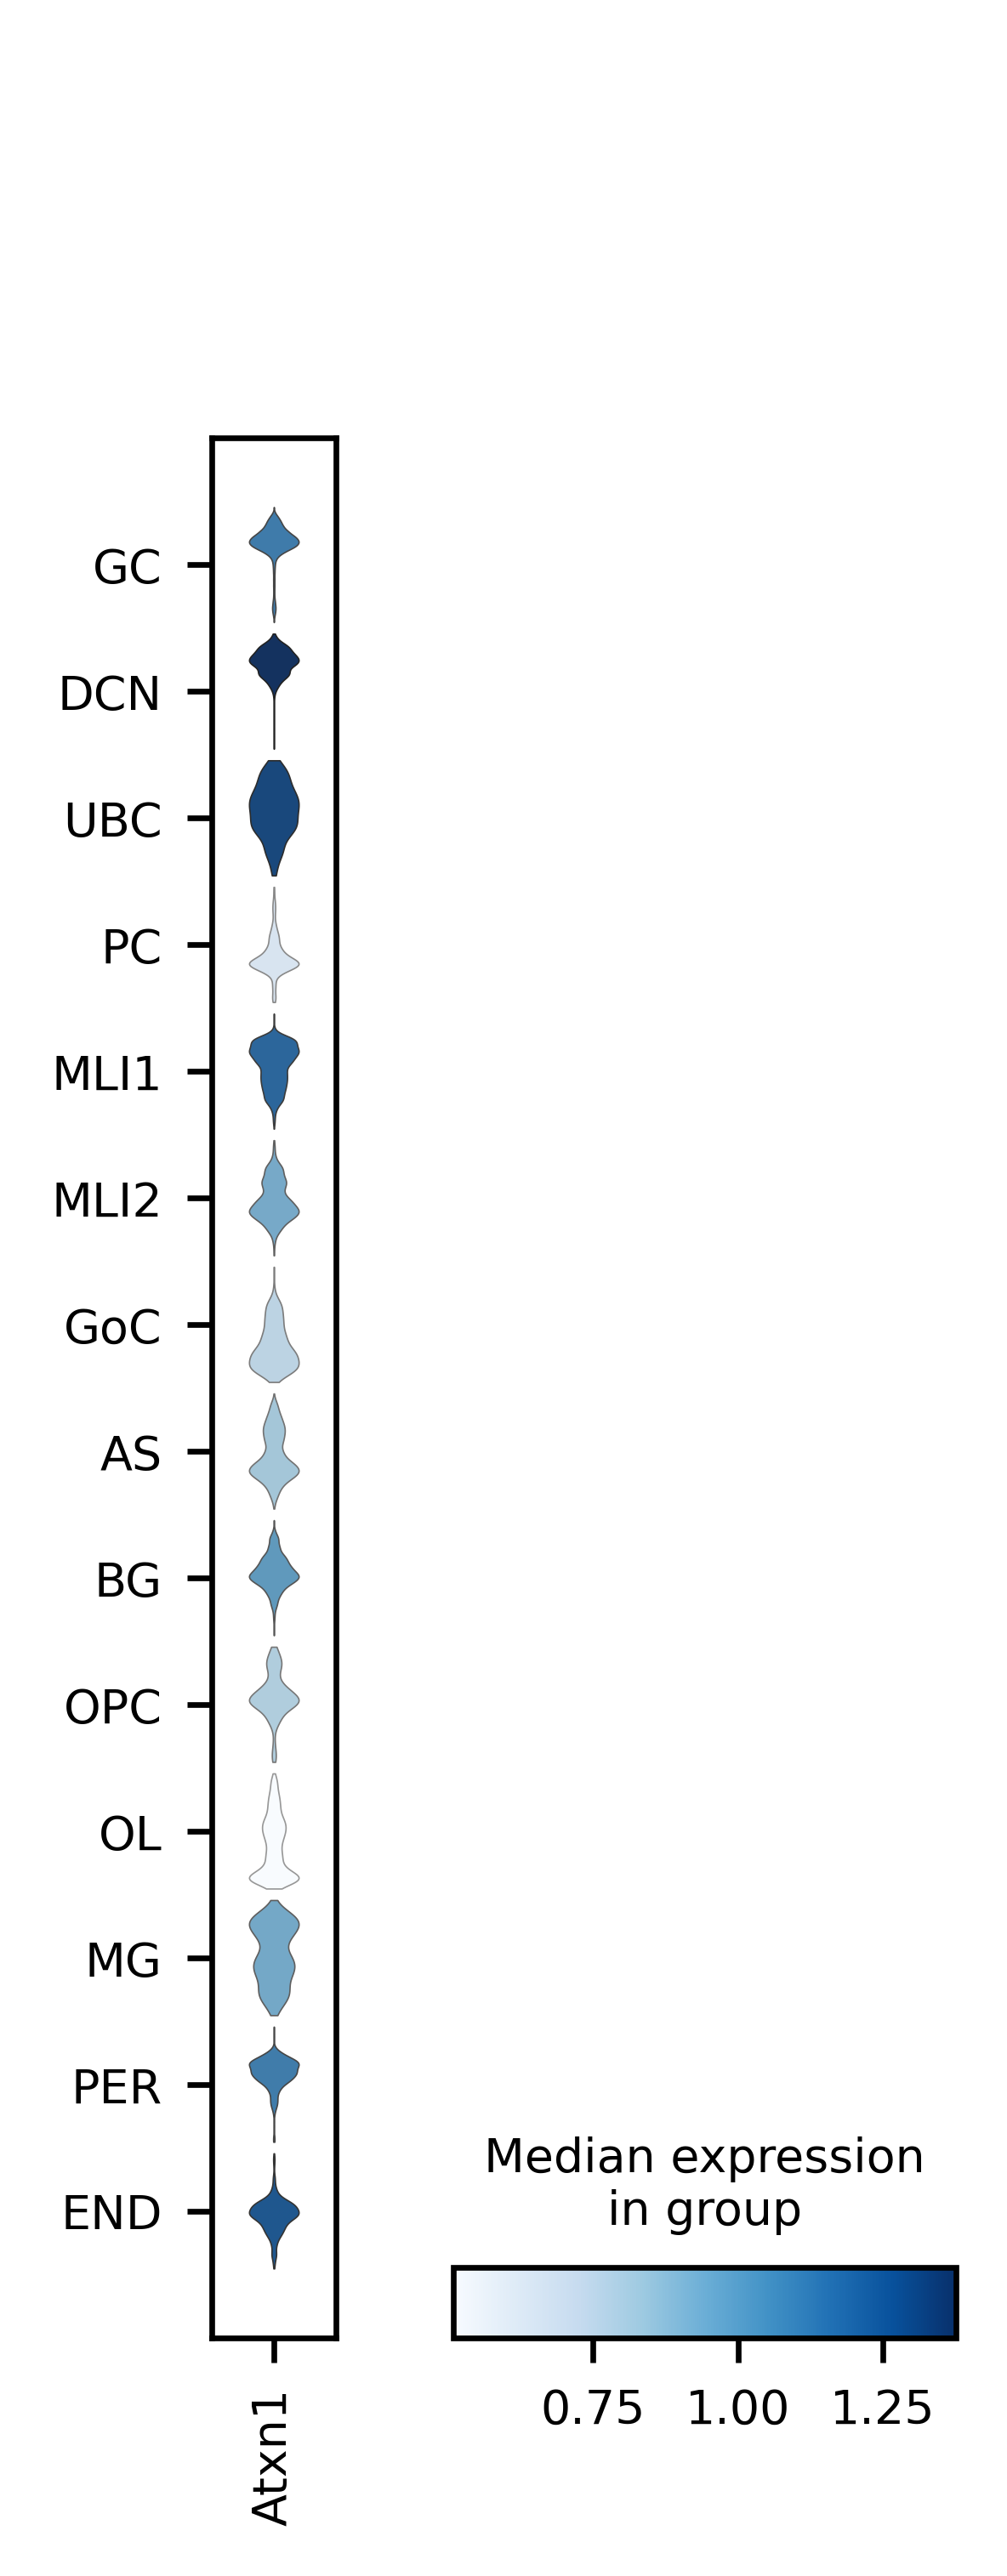

In [15]:
sc.pl.stacked_violin(adata,'Atxn1', groupby=['sub4'], layer = 'imputed', use_raw=False, rotation= 90)

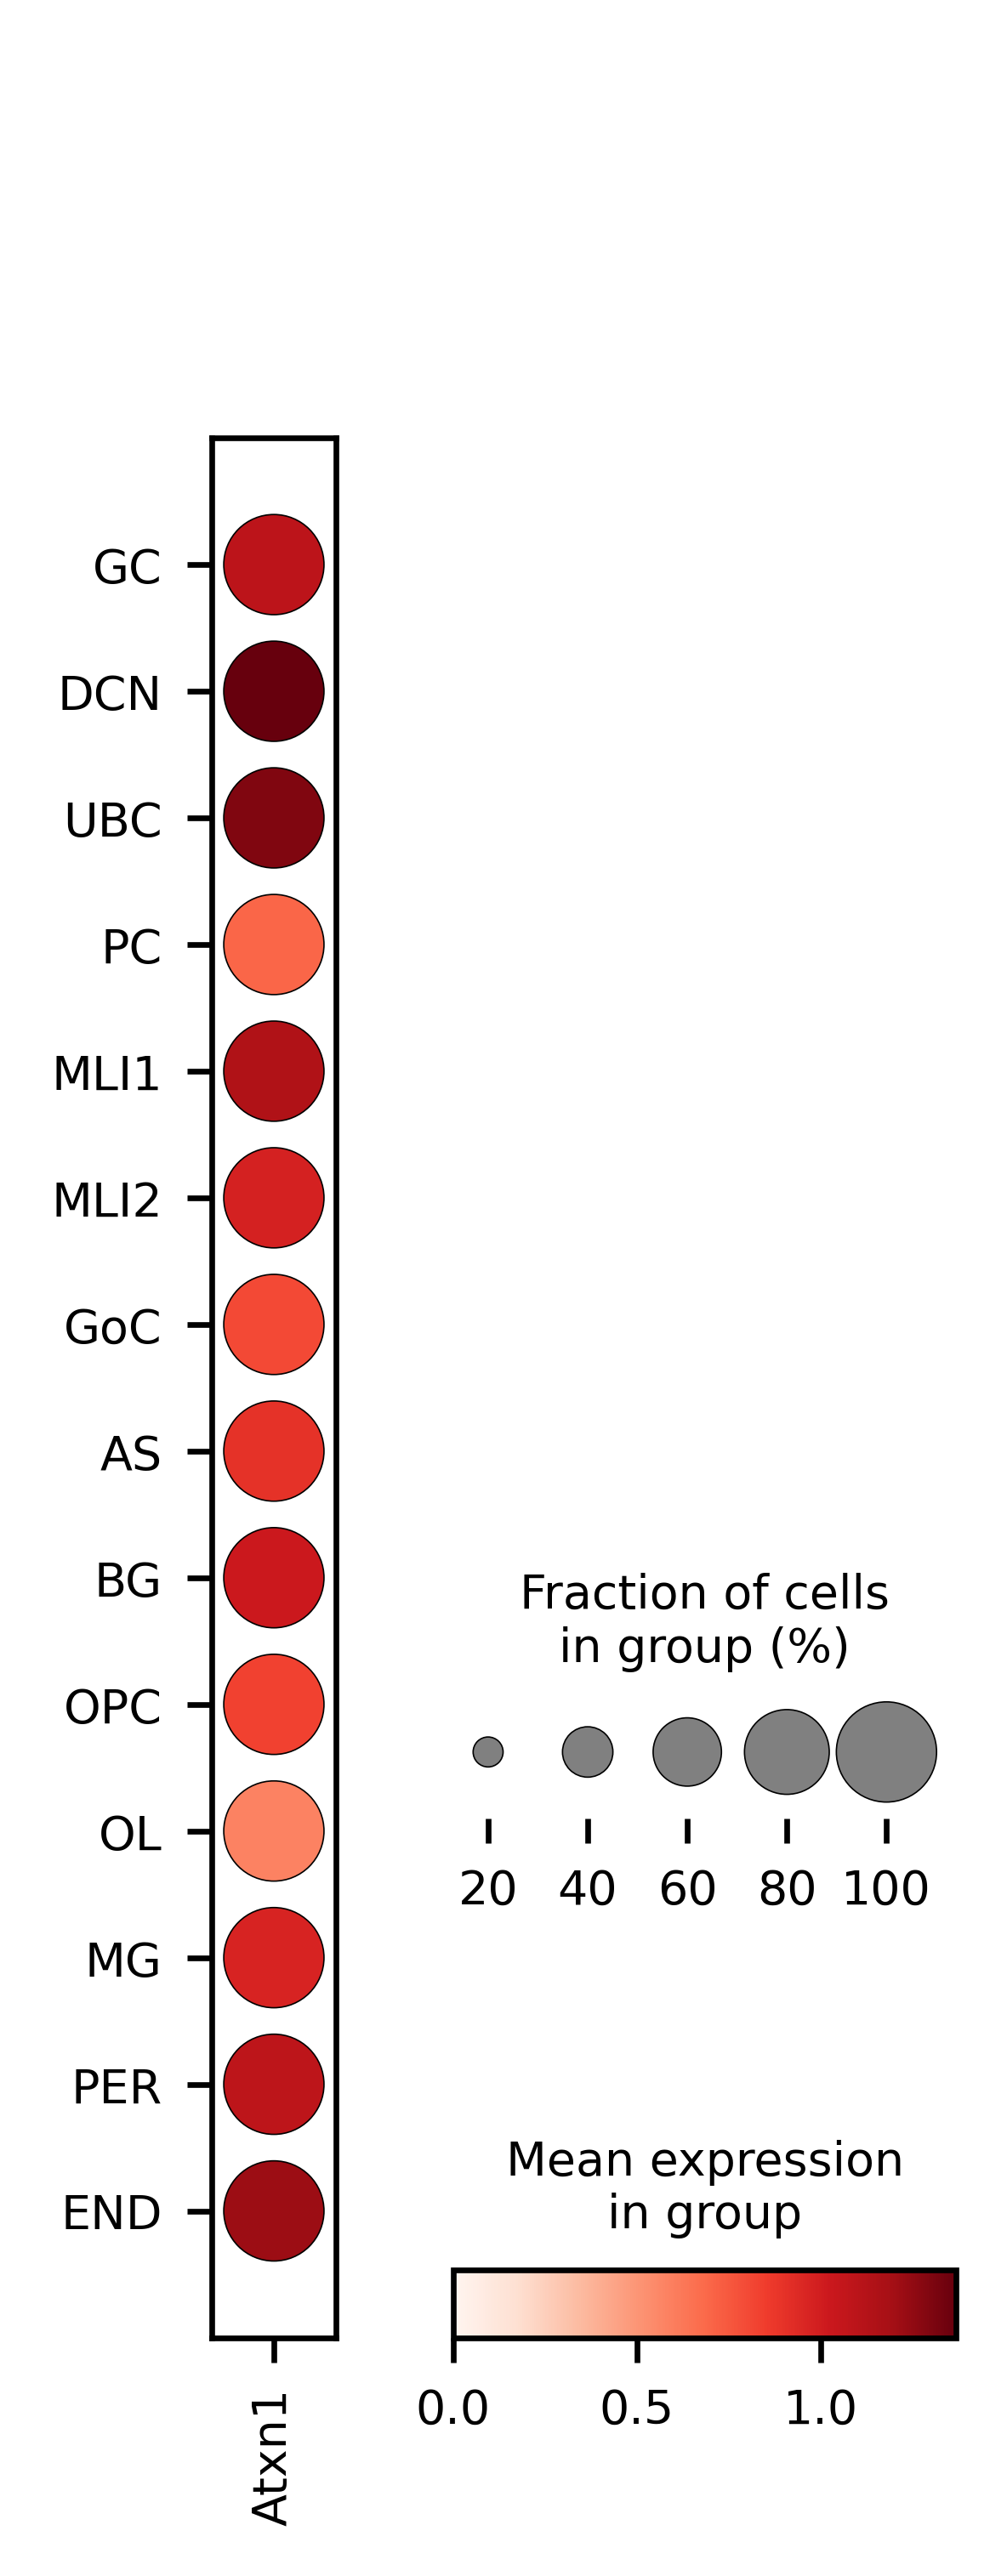

In [26]:
sc.pl.dotplot(adata,'Atxn1', groupby=['sub4'], layer = 'imputed', use_raw=False, vmin=0)

In [34]:
##Original - use for UMAP

cmap_sub4={'GC': '#FAC18A',
            'DCN': '#AAABAB',
            'UBC': '#BA61BA',
            'PC': '#EE5264',
            'MLI1': '#F9EBAE',
            'MLI2': '#88BB92',
            'GoC': '#46A928',
            'AS': '#F9AEAE',
            'BG': '#AEB7F9',
            'OPC': '#F1815F',
            'OL': '#75A3B7',
            'MG': '#AC5861',
            'PER': '#2D284B',
            'END': '#1C67EE'}

adata.uns['sub4_colors']=np.array(list(cmap_sub4.values()),dtype=object)
adata.obs['sub4'].cat.reorder_categories(new_categories=list(cmap_sub4.keys()),
                                         inplace=True,ordered=True)

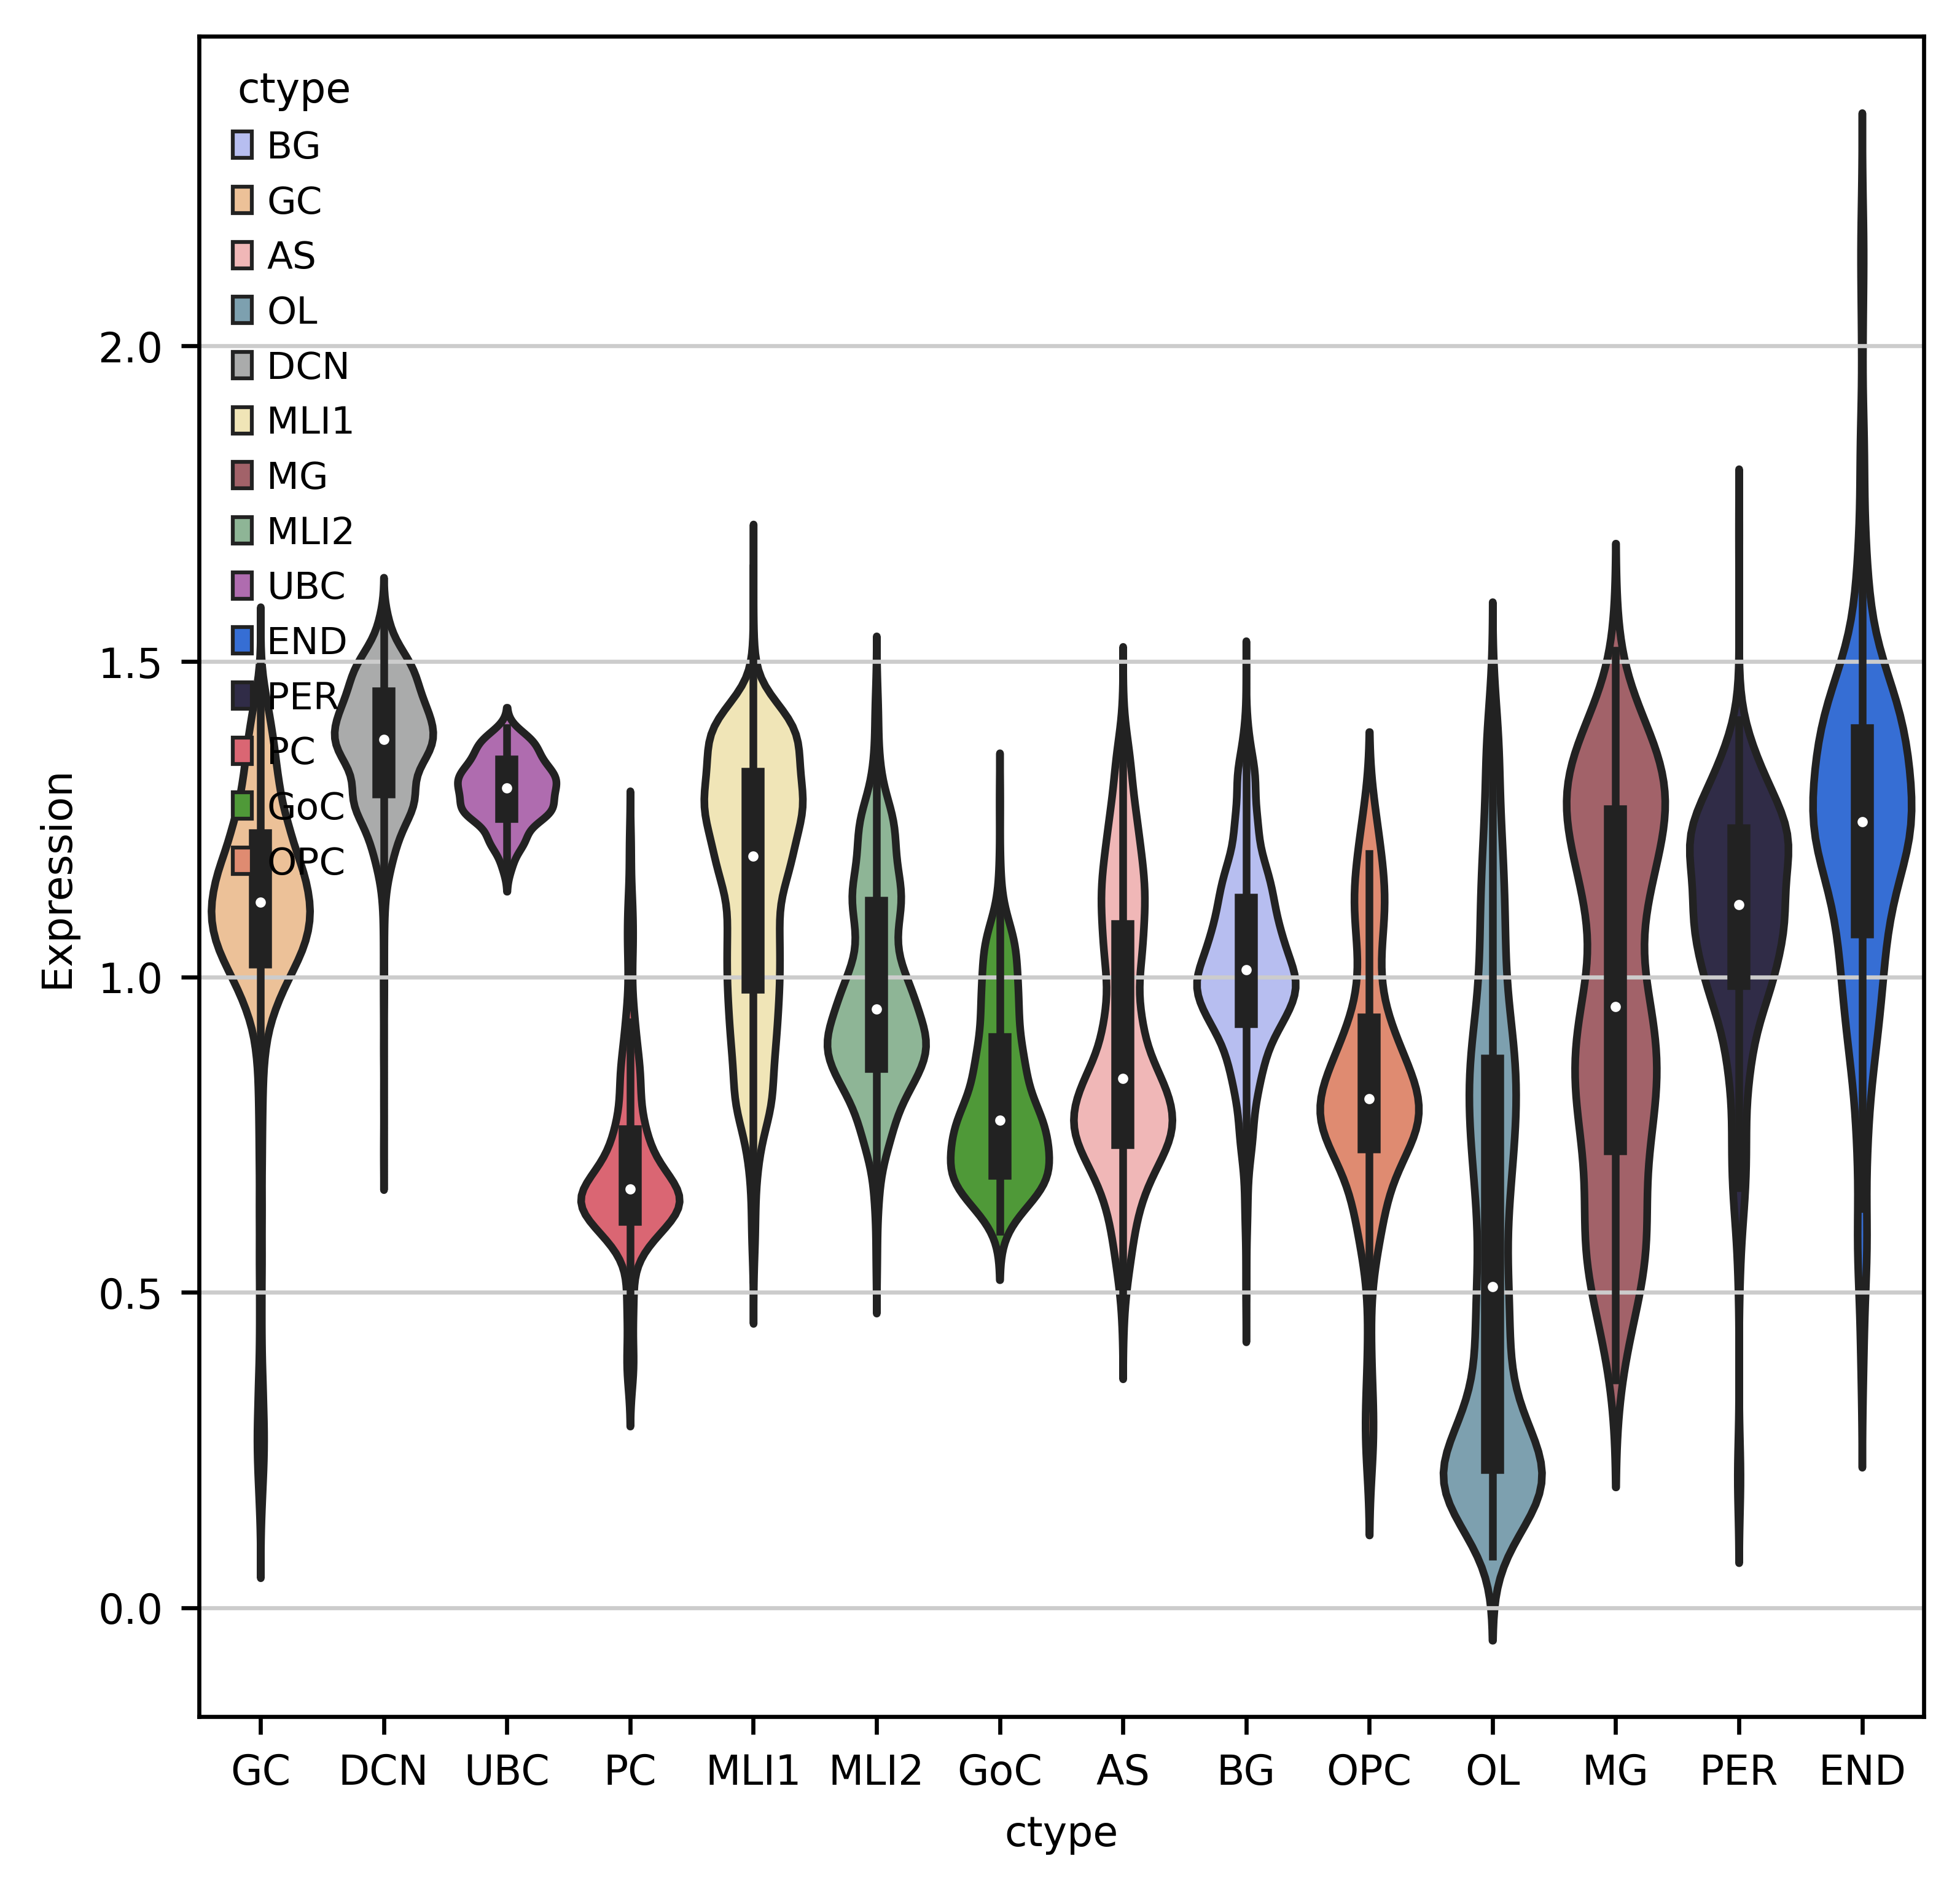

In [40]:
fig,ax = plt.subplots(1, 1, figsize=(6,6))
ax = sns.violinplot(
        x='ctype',
        y='Expression',
        hue='ctype',
        data=X,
        order=['GC','DCN','UBC','PC','MLI1','MLI2','GoC','AS','BG','OPC','OL','MG','PER','END'],
        bw='scott',
        #cut=2,
        scale='area',
        scale_hue=True,
        gridsize=100,
        #width=0.8,
        inner='box',
        split=False,
        dodge=False,
        orient=None,
        linewidth=None,
        color=None,
        #cmap = cmap_sub4,
        palette=cmap_sub4,
        saturation=0.75,
)
fig.savefig(os.path.join(pfp, '220517_Atxn1_expression_by_ctype_violin.pdf'), bbox_inches='tight')

In [9]:
X.head()

,ctype,genotype,timepoint,Atxn1,Expression
0,BG,WT,5wk,0,1.145010
1,GC,WT,5wk,0,0.000000
2,AS,WT,5wk,0,0.000000
3,GC,WT,5wk,0,1.633897
4,GC,WT,5wk,0,1.688759
